<a href="https://colab.research.google.com/github/novrian6/review_cnn/blob/main/review_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [ ]:
# Define the URL to download the dataset (Stanford Dogs Dataset)
data_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
custom_target_dir = "contents"


In [ ]:
data_dir = tf.keras.utils.get_file('stanford_dogs', data_url, extract=True, untar=True, cache_dir=custom_target_dir)


793579520/793579520 [==============================] - 255s 0us/step


In [ ]:
data_dir

'/tmp/.keras/datasets/stanford_dogs'

In [ ]:
# Create a TensorFlow dataset from the images
image_size = (128, 128)  # Adjust as needed
batch_size = 32  # Adjust as needed

In [ ]:
# Define a function to load and preprocess images
def preprocess_image(image, label):
    # Resize images to a consistent size
    image = tf.image.resize(image, image_size)
    # Normalize pixel values to be in the range [0, 1]
    image = image / 255.0
    return image, label

In [ ]:
# Create a dataset using TensorFlow Datasets (TFDS)
dataset_name = "stanford_dogs"  # Replace with the dataset name

In [ ]:
# Split the dataset into train, validation, and test sets
(ds_train, ds_test, ds_valid), ds_info = tfds.load(
    dataset_name,
    split=["train[:70%]", "train[85%:]", "train[70%:85%]"],  # Train, test, and validation splits
    with_info=True,
    data_dir=data_dir,
    as_supervised=True,
)


In [ ]:
# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)
ds_valid = ds_valid.map(preprocess_image)

In [ ]:
# Shuffle and batch the datasets
ds_train = ds_train.shuffle(buffer_size=1000).batch(batch_size)
ds_test = ds_test.batch(batch_size)
ds_valid = ds_valid.batch(batch_size)

# Optionally, prefetch data for better performance
ds_train = ds_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Define a function to display images from the dataset
def show_images(ds, num_images=9):
    plt.figure(figsize=(12, 12))
    for i, (images, labels) in enumerate(ds.take(1)):  # Display the first batch of images
        for j in range(min(images.shape[0], num_images)):
            ax = plt.subplot(3, 3, j + 1)
            plt.imshow(images[j].numpy())
            plt.title(f"Class: {labels[j].numpy()}")
            plt.axis("off")
    plt.show()


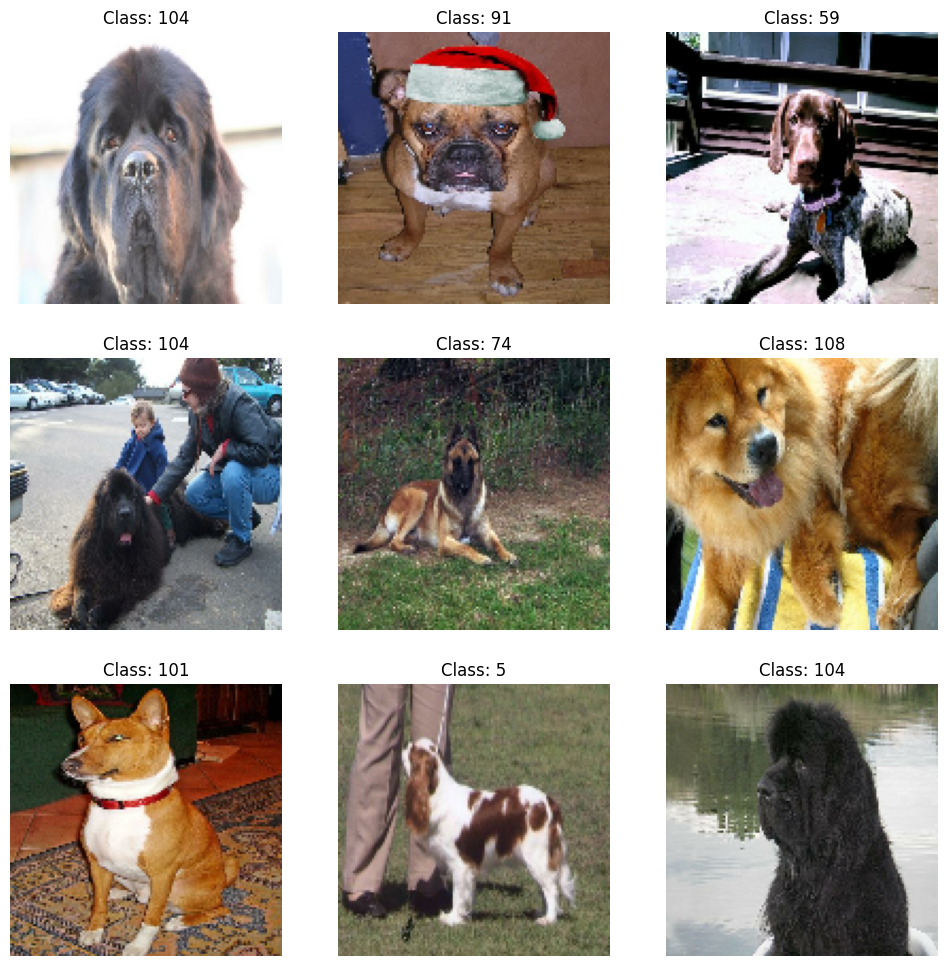

In [ ]:
# Display the first 9 training images
show_images(ds_train, num_images=9)

In [ ]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
              metrics=['accuracy'])

# Define the number of training epochs
epochs = 10  # Adjust as needed

# Train the model
history = model.fit(ds_train, epochs=epochs, validation_data=ds_valid)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Optionally, save the trained model
model_filename = 'stanford_dogs_cnn_model.h5'
model.save(model_filename)
print(f"Model saved as '{model_filename}'")

# Make predictions on new data
# For demonstration purposes, you can use a batch of data from the test set
sample_batch = next(iter(ds_test))
sample_images, sample_labels = sample_batch

predictions = model.predict(sample_images)


Epoch 1/10
 76/263 [=======>......................] - ETA: 3:37 - loss: 4.7932 - accuracy: 0.0086